In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
import backtrader as bt
import pyfolio as pf
%matplotlib inline

In [2]:
class BaseStrategy(bt.Strategy):
    
    def __init__(self):
        pass
    
    def next(self):
        pass
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def log_candles(self):
        self.log('===>')
        self.log('Current Open: {}, Close: {}'.format(self.data0.open[0],self.data0.close[0]))
        self.log('Next Open: {}, Close: {}'.format(self.data0.open[1],self.data0.close[1]))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

# Rob Hanna strategy

In [24]:
class TestStrategy(BaseStrategy):
    def __init__(self):
        self.closes_down = self.data0.close < self.data0.open
        self.rsi2_90 = bt.indicators.RSI(self.data0, period=2) > 90
        self.close_200 = self.data0.close > bt.indicators.SimpleMovingAverage(period=200)
        
    def next(self):
        if self.position and len(self) >= (self.buy_executed + 2):
            self.sell(exectype=bt.Order.Close)
            self.buy_executed = None
        
        if self.closes_down and self.rsi2_90 and self.close_200:
            self.buy(exectype=bt.Order.Market)
            self.buy_executed = len(self)
            self.log_candles()

In [25]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname='SPX',
    fromdate=datetime(1995,1,1),
    todate=datetime(2018,1,1),
    reverse=True)

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2004-05-14, ===>
2004-05-14, Current Open: 3.69, Close: 3.5
2004-05-14, Next Open: 3.0, Close: 3.12
2004-05-17, BUY EXECUTED, 3.50
2004-05-19, SELL EXECUTED, 3.62
2007-02-23, ===>
2007-02-23, Current Open: 3.0, Close: 2.75
2007-02-23, Next Open: 2.87, Close: 3.37
2007-02-26, BUY EXECUTED, 2.75
2007-02-28, SELL EXECUTED, 3.00
2007-06-11, ===>
2007-06-11, Current Open: 1.81, Close: 1.75
2007-06-11, Next Open: 0.28, Close: 0.28
2007-06-12, BUY EXECUTED, 1.75
2007-06-14, SELL EXECUTED, 0.26
2007-07-27, ===>
2007-07-27, Current Open: 1.87, Close: 1.75
2007-07-27, Next Open: 0.19, Close: 0.19
2007-07-30, BUY EXECUTED, 1.75
2007-08-01, SELL EXECUTED, 0.19
2010-03-25, ===>
2010-03-25, Current Open: 0.35, Close: 0.32
2010-03-25, Next Open: 0.06, Close: 0.05
2010-03-26, BUY EXECUTED, 0.32
2010-03-30, SELL EXECUTED, 0.05
2010-04-26, ===>
2010-04-26, Current Open: 0.32, Close: 0.3
2010-04-26, Next Open: 0.05, Close: 0.05
2010-04-27, BUY EXECUTED, 0.30
2010-04-29

Entire data start date: 2002-02-20
Entire data end date: 2017-12-29
Backtest months: 189


C:\DEV\Anaconda3\envs\trading\lib\site-packages\empyrical\stats.py:954: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


,Backtest
Annual return,-22.0%
Cumulative returns,-98.0%
Annual volatility,36.5%
Sharpe ratio,-0.46
Calmar ratio,-0.22
Stability,0.87
Max drawdown,-98.3%
Omega ratio,0.32
Sortino ratio,-0.54
Skew,-4.39


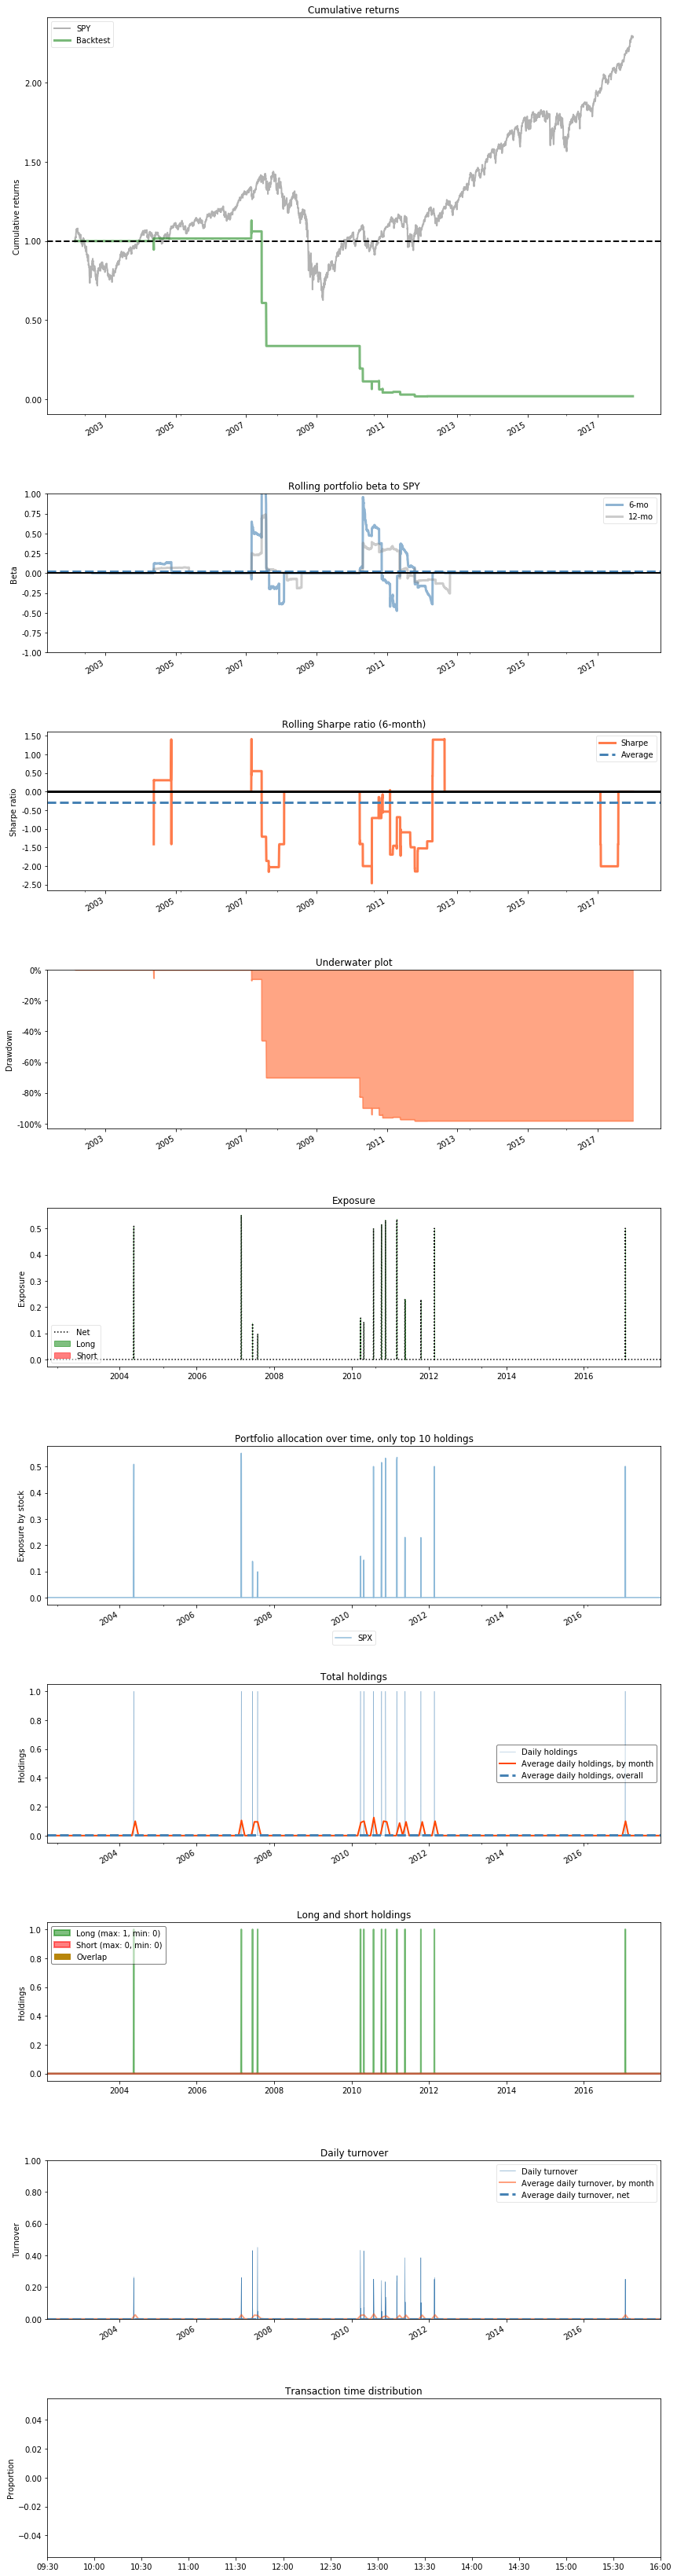

In [26]:
pf.create_simple_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions)